<a href="https://colab.research.google.com/github/joshualin24/EEG_demo/blob/main/EEGBCI_Self_Supervised_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Self-Supervised Learning on EEGBCI Motor Movement/Imagery Dataset

This notebook trains self-supervised learning models on the [EEGBCI dataset](http://www.ncbi.nlm.nih.gov/pubmed/15188875) on [PhysioNet](https://www.ahajournals.org/doi/10.1161/01.CIR.101.23.e215), including using the [SeqCLR](https://proceedings.mlr.press/v136/mohsenvand20a.html) and the [DINO](https://arxiv.org/abs/2104.14294) frameworks. Detailed data description and experimental protocol can be found [here](https://physionet.org/content/eegmmidb/1.0.0/#files-panel).

# Prerequisite

In [1]:
!pip install pytorch_lightning
!pip install mne==0.24.1

In [2]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, ConcatDataset, DataLoader, Subset
import pytorch_lightning as pl
import torchaudio
import mne
import random
import math
import os
from google.colab import files
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from typing import Optional, Callable, Type
from collections.abc import Sequence

In [3]:
%load_ext tensorboard

Some global variables:

In [4]:
EVENT_ID = {  # integer identifier of experimental tasks/events
    'rest/eye-open': 0,
    'rest/eye-closed': 1,
    'movement/left/fist': 2,
    'movement/right/fist': 3,
    'imagery/left/fist': 4,
    'imagery/right/fist': 5,
    'movement/both/fist': 6,
    'movement/both/foot': 7,
    'imagery/both/fist': 8,
    'imagery/both/foot': 9
}

NUM_SUBJECTS = 109
SUBJECTS_EXCLUDED = [88, 92, 100]  # outliers with a different sample frequency
SUBJECTS = [i for i in range(1, NUM_SUBJECTS+1) if i not in SUBJECTS_EXCLUDED]

NUM_RUNS = 14
RUNS = [i for i in range(1, NUM_RUNS+1)]

# Dataset Preparation

In [5]:
def extract_windows(
    raw: mne.io.Raw,
    subject: int,
    run: int,
    event_id: dict,
    num_steps: int = 640,
    baseline_duration: float = 0.2
):
    """
    Return windows/epochs extracted from raw data.

    Arguments
    ---------
    raw: Raw data
    subject: Subject of recording
    run: Experimental run
    event_id: Mapping from tasks/events to integer identifiers
    num_steps: Number of time steps in a window (excluding baseline segment)
    baseline_duration: Duration of baseline for drift correction
    
    Note
    ----
    Baseline segments are not discarded from the returned windows.
    """
    duration = (num_steps - 1) / raw.info['sfreq']
    events, focal_event_id = get_events(raw, run, event_id, duration)
    metadata = pd.DataFrame({
        'start': events[:, 0] / raw.info['sfreq'],  # start time of tasks
        'task': events[:, -1],  # identifier of experimental tasks
        'subject': subject,
        'run': run
    })
    event_mapping = {ind: key for key, ind in event_id.items()}
    epochs = mne.Epochs(
        raw,
        events,
        event_id={event_mapping[ind]: ind for ind in focal_event_id.values()},
        tmin=-baseline_duration,
        tmax=duration,
        metadata=metadata,
        verbose=False
    )
    drop_bad_epochs(
        epochs,
        raw,
        int(duration * raw.info['sfreq']),
        int(baseline_duration * raw.info['sfreq'])
    )
    return epochs


def get_events(
    raw: mne.io.Raw,
    run: int,
    event_id: dict,
    fixed_length_duration: float
):
    """
    Return tuple of events and their integer-identifier-mapping according to
    the experimental run.

    Argmuments
    ----------
    raw: Raw data
    run: Experimental run
    event_id: Mapping from tasks/events to integer identifiers
    fixed_length_duration: Duration to create fixed-length events

    Note
    ----
    For runs with alternating experimental tasks, the rest-state periods in
    between will not be considered.
    """
    if run in (1, 2):
        events = mne.make_fixed_length_events(
            raw,
            id=run,
            duration=fixed_length_duration
        )
        return events, {'T0': run}
    elif run in (3, 7, 11):
        event_id = {
            'T1': event_id['movement/left/fist'],
            'T2': event_id['movement/right/fist']
        }
        return mne.events_from_annotations(raw, event_id, verbose=False)
    elif run in (4, 8, 12):
        event_id = {
            'T1': event_id['imagery/left/fist'],
            'T2': event_id['imagery/right/fist']
        }
        return mne.events_from_annotations(raw, event_id, verbose=False)
    elif run in (5, 9, 13):
        event_id = {
            'T1': event_id['movement/both/fist'],
            'T2': event_id['movement/both/foot']
        }
        return mne.events_from_annotations(raw, event_id, verbose=False)
    elif run in (6, 10, 14):
        event_id = {
            'T1': event_id['imagery/both/fist'],
            'T2': event_id['imagery/both/foot']
        }
        return mne.events_from_annotations(raw, event_id, verbose=False)
    else:
        raise ValueError('invalid experimental run.')


def drop_bad_epochs(
    epochs: mne.Epochs,
    raw: mne.io.Raw,
    epoch_steps: int,
    baseline_steps: int
) -> None:
    """
    In-place drop epochs that are too short or lack baseline data.

    Arguments
    ---------
    epochs: Epochs to manipulate
    raw: Raw data from which epochs were extracted
    epoch_steps: Number of time steps per epoch
    baseline_steps: Number of time steps of baseline period
    """
    # Drop epochs with fewer steps than the pre-specified number
    mask = (raw.n_times - 1 - epochs.events[:, 0]) < epoch_steps
    epochs.drop(mask, reason='USER: TOO SHORT', verbose=False)
    # Drop epochs which lack baseline data
    mask = (epochs.events[:, 0] - baseline_steps) < 0
    epochs.drop(mask, reason='USER: NO BASELINE', verbose=False)

In [6]:
def download_eegbci(
    subjects: list,
    runs: list,
    dir: str = './'
) -> None:
    """
    Download the EEGBCI motor movement/imagery dat.

    Arguments
    ---------
    subjects: List of subjects of interest
    runs: List of experimental runs for each subject
    dir: Root directory path to the EEGBCI data
    """
    for subject in subjects:
        mne.datasets.eegbci.load_data(subject, runs, path=dir)


def eegbci_epochs_collection(
    subjects: list,
    runs: list,
    dir: str = './',
    **kwargs
) -> list:
    """
    Return extracted windows/epochs from the EEGBCI motor movement/imagery data.

    Arguments
    ---------
    subjects: List of subjects of interest
    runs: List of experimental runs for each subject
    dir: Root directory path to the EEGBCI data
    kwargs: Keyword arguments passed to extract windows
    
    Note
    ----
    Baseline segments are not discarded from the returned windows.
    """
    epochs_list = [
        extract_windows(
            mne.io.read_raw_edf(
                mne.datasets.eegbci.load_data(subject, run, path=dir)[0],
                verbose=False
            ),
            subject,
            run,
            EVENT_ID,
            **kwargs
        ) for subject in subjects for run in runs
    ]
    return epochs_list

In [7]:
class WindowDataset(Dataset):
    """Dataset of extracted windows/epochs."""

    def __init__(
        self,
        windows: mne.Epochs,
        get_label: Callable,
        transform: Callable = None,
        target_transform: Callable = None
    ):
        """
        Arguments
        ---------
        windows: Extracted windows
        get_label: Function to extract label from metadata
        transform: Transformation upon data
        target_transform: Transformation upon labels
        
        Note
        ----
        Baseline segments are discarded from the returned windows.
        """
        super().__init__()
        self.windows = windows
        self.get_label = get_label
        self.transform = transform
        self.target_transform = target_transform
    
    def __len__(self):
        return len(self.windows.events)
    
    def __getitem__(self, ind: int):
        window = self.windows[ind]
        data = window.get_data(tmin=0.0)[0]  # baseline discarded
        data = torch.from_numpy(data).float()  # convert to float32 tensor
        if self.transform: data = self.transform(data)
        label = self.get_label(window.metadata)
        if self.target_transform: label = self.target_transform(label)
        return data, label


class EEGBCIDataset(ConcatDataset):
    """Dataset of the EEGBCI motor movement/imagery data."""

    def __init__(
        self,
        subjects: list,
        runs: list,
        num_steps: int,
        get_label: Callable,
        transform: Callable = None,
        target_transform: Callable = None,
        **kwargs
    ):
        """
        Arguments
        ---------
        subjects: List of subjects of interest
        runs: List of experimental runs for each subject
        num_steps: Number of time points in each extracted window
        get_label: Function to extract label from metadata
        transform: Transformation upon data
        target_transform: Transformation upon labels
        kwargs: Keyword arguments passed to extract windows
        """
        epochs = eegbci_epochs_collection(
            subjects,
            runs,
            num_steps=num_steps,
            **kwargs
        )
        datasets = [
            WindowDataset(windows, get_label, transform, target_transform)
            for windows in epochs
        ]
        super().__init__(datasets)
        self.metadata = pd.concat([windows.metadata for windows in epochs])

# Augmentations & Transformations

In [8]:
class Identity:
    """No augmentation applies."""

    def __init__(self):
        pass
    
    def __call__(self, data: torch.Tensor):
        return data


class DCShift:
    """Add a random constant shift to data."""

    def __init__(self, min_shift: float, max_shift: float):
        self.base = min_shift
        self.scale = max_shift - min_shift

    def __call__(self, data: torch.Tensor):
        """Data must have dimensions `(..., time steps)`."""
        shifts = self.base + self.scale * torch.rand_like(data[..., :1])
        return data + shifts


class AmplitudeScale:
    """Scale data with a randomly selected constant."""

    def __init__(self, min_scale: float, max_scale: float):
        self.base = min_scale
        self.scale = max_scale - min_scale

    def __call__(self, data: torch.Tensor):
        """Data must have dimensions `(..., time steps)`."""
        scales = self.base + self.scale * torch.rand_like(data[..., :1])
        return data * scales


class AdditiveGaussianNoise:
    """Add Gaussian noise with a random standard deviation."""

    def __init__(self, min_sigma: float, max_sigma: float):
        self.base = min_sigma
        self.scale = max_sigma - min_sigma

    def __call__(self, data: torch.Tensor):
        """Data must have dimensions `(..., time steps)`."""
        sigmas = self.base + self.scale * torch.rand_like(data[..., :1])
        return data + torch.randn_like(data) * sigmas


class TimeMasking:
    """Mask data for a randomly selected time segment."""

    def __init__(self, min_len: int, max_len: int, mask_val: float = 0.0):
        self.base = min_len
        self.scale = max_len - min_len
        self.val = mask_val
    
    def __call__(self, data: torch.Tensor):
        """Data must have dimensions `(..., time steps)`."""
        lens = self.base + self.scale * torch.rand_like(data[..., :1])
        starts = (data.size(-1) - lens) * torch.rand_like(data[..., :1])
        ends = starts + lens
        inds = torch.arange(data.size(-1), dtype=data.dtype, device=data.device)
        return data.masked_fill((inds >= starts) & (inds < ends), self.val)


class TimeShift:
    """Shift data along the time axis with a periodic boundary condition."""

    def __init__(self, min_shift: int, max_shift: int):
        self.base = min_shift
        self.scale = max_shift - min_shift
    
    def __call__(self, data: torch.Tensor):
        """Data must have dimensions `(..., time steps)`."""
        shifts = self.base + self.scale * torch.rand_like(data[..., :1])
        shifts = torch.remainder(shifts, data.size(-1))
        # Prepare indices for masking
        inds = torch.arange(data.size(-1), dtype=data.dtype, device=data.device)
        inds_rev = data.size(-1) - 1 - inds
        # Allocate and fill in shifted data
        shifted = torch.empty_like(data)
        shifted[inds < shifts] = data[inds_rev < shifts]
        shifted[inds >= shifts] = data[inds_rev >= shifts]
        return shifted


class BandStopFilter:
    """Filter out data for a frequency band."""

    def __init__(self, min_freq, max_freq, bandwidth, sample_rate):
        self.base = min_freq
        self.scale = max_freq - min_freq
        self.bandwidth = bandwidth
        self.sample_rate = sample_rate

    def __call_(self, data: torch.Tensor):
        """Data must have dimensions `(..., time steps)`."""
        central_freqs = self.base + self.scale * torch.rand_like(data[..., :1])
        return torchaudio.functional.bandreject_biquad(
            data,
            self.sample_rate,
            central_freqs,
            central_freqs / self.bandwidth
        )

# Self-Supervised Learning Frameworks & Models

## SeqCLR (adopted from SimCLR)

See reference [here](https://proceedings.mlr.press/v136/mohsenvand20a.html):

Mohsenvand, M.N., Izadi, M.R. &amp; Maes, P.. (2020). Contrastive Representation Learning for Electroencephalogram Classification. <i>Proceedings of the Machine Learning for Health NeurIPS Workshop</i>, in <i>Proceedings of Machine Learning Research</i> 136:238-253

In [ ]:
class RandomAugmentationPair:
    """Randomly selected pair of augmentations from a given collection."""

    def __init__(self, augmentations: Sequence):
        self.augs = augmentations
    
    def __call__(self, data: torch.Tensor):
        """Return tuple of augmented data."""
        aug_1, aug_2 = random.sample(self.augs, 2)
        return aug_1(data), aug_2(data)

In [ ]:
class ContrastiveLoss(nn.Module):
    """
    Constrative loss function in the SimCLR framework.

    Notes
    -----
    1. Full credit to https://zablo.net/blog/post/understanding-implementing-simclr-guide-eli5-pytorch/.
    2. See also Chen, Ting, et al. "A simple framework for contrastive learning
       of visual representations." International conference on machine learning.
       PMLR, 2020.
    """

    def __init__(self, batch_size: int, temperature: float = 0.5):
        """
        Arguments
        ---------
        batch_size: Batch size (as well as the size of candidate pool)
        temperature: Parameter of sharpness
        """
        super().__init__()
        self.batch_size = batch_size
        self.register_buffer("temperature", torch.tensor(temperature))
        self.register_buffer(
            "negatives_mask",
            (~torch.eye(batch_size*2, batch_size*2, dtype=bool)).float()
        )
            
    def forward(self, emb_i: torch.Tensor, emb_j: torch.Tensor):
        """
        Return the Boltzmann distribution of positive pairs, where the energy
        function is the cosine similarity between embeddings.
        """
        z_i = torch.nn.functinal.normalize(emb_i, dim=1)
        z_j = torch.nn.functinal.normalize(emb_j, dim=1)
        representations = torch.cat([z_i, z_j], dim=0)
        # Compute cosine similarity between positive pairs
        similarity_matrix = torch.nn.functinal.cosine_similarity(
            representations.unsqueeze(1),
            representations.unsqueeze(0),
            dim=2
        )
        sim_ij = torch.diag(similarity_matrix, self.batch_size)
        sim_ji = torch.diag(similarity_matrix, -self.batch_size)
        positives = torch.cat([sim_ij, sim_ji], dim=0)
        # Compute loss value
        nominator = torch.exp(positives / self.temperature)
        denominator = self.negatives_mask * torch.exp(similarity_matrix / self.temperature)
        loss_partial = -torch.log(nominator / torch.sum(denominator, dim=1))
        loss = torch.sum(loss_partial) / (2 * self.batch_size)
        return loss

In [ ]:
class SeqCLR(pl.LightningModule):
    """Contrastive learning on individual channels of EEG data."""

    def __init__(
        self,
        encoder: nn.Module,
        projector: nn.Module,
        augmentations: Sequence,
        batch_size: int,
        temperature: float = 5e-2,
        learning_rate: float = 1e-4,
        weight_decay: float = 1e-4
    ):
        """
        Arguments
        ---------
        encoder: Encoder module that extract representation from data
        projector: Projection head module
        augmentations: Collection of augmentations of interests
        batch_size: Batch size of training/validation set
        temperature: Temperature of contrastive loss
        learning_rate: Learning rate of optimizer
        weight_decay: Weight decay of optimizer
        """
        super().__init__()
        self.save_hyperparameters()
        self.encoder = encoder
        self.projector = projector
        self.augmentation_pair = RandomAugmentationPair(augmentations)
        self.criterion = ContrastiveLoss(batch_size, temperature)
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
    
    def forward(self, data: torch.Tensor):
        """
        Return the learned representation of data.

        Note
        ----
        Data must have dimensions `(batch, channels, ..., time steps)`.
        """
        repr = self.encoder(data.flatten(end_dim=1))
        return repr.unflatten(0, data.size()[:2])
    
    def training_step(self, batch, batch_ind):
        loss = self._shared_step(batch, batch_ind)
        self.log('Train/Loss', loss)
        return loss
    
    def validation_step(self, batch, batch_ind):
        loss = self._shared_step(batch, batch_ind)
        self.log('Validation/Loss', loss)
    
    def _shared_step(self, batch, batch_ind):
        """Return loss of the current batch."""
        data, = batch
        data = data.flatten(end_dim=1)  # flatten channels into the batch
        augmented_1, augmented_2 = self.augmentation_pair(data)
        loss = self.criterion(
            self.projector(self.encoder(augmented_1)),
            self.projector(self.encoder(augmented_2))
        )
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.parameters(),
            lr=self.learning_rate,
            weight_decay=self.weight_decay
        )
        return optimizer

## DINO

See reference [here](https://openaccess.thecvf.com/content/ICCV2021/html/Caron_Emerging_Properties_in_Self-Supervised_Vision_Transformers_ICCV_2021_paper.html):

Mathilde Caron, Hugo Touvron, Ishan Misra, Hervé Jégou, Julien Mairal, Piotr Bojanowski, Armand Joulin; Proceedings of the IEEE/CVF International Conference on Computer Vision (ICCV), 2021, pp. 9650-9660

In [9]:
class WeightNorm(nn.Module):
    """
    Weight normalization implementation insensitive to deep copying.

    Full credit to https://gist.github.com/rtqichen/b22a9c6bfc4f36e605a7b3ac1ab4122f.
    """
    append_g = '_g'
    append_v = '_v'

    def __init__(self, module, weights):
        super(WeightNorm, self).__init__()
        self.module = module
        self.weights = weights
        self._reset()

    def _reset(self):
        for name_w in self.weights:
            w = getattr(self.module, name_w)

            # construct g,v such that w = g/||v|| * v
            g = torch.norm(w)
            v = w/g.expand_as(w)
            g = nn.Parameter(g.data)
            v = nn.Parameter(v.data)
            name_g = name_w + self.append_g
            name_v = name_w + self.append_v

            # remove w from parameter list
            del self.module._parameters[name_w]

            # add g and v as new parameters
            self.module.register_parameter(name_g, g)
            self.module.register_parameter(name_v, v)

    def _setweights(self):
        for name_w in self.weights:
            name_g = name_w + self.append_g
            name_v = name_w + self.append_v
            g = getattr(self.module, name_g)
            v = getattr(self.module, name_v)
            w = v*(g/torch.norm(v)).expand_as(v)
            setattr(self.module, name_w, w)

    def forward(self, *args):
        self._setweights()
        return self.module.forward(*args)


class PositionalEncoding(nn.Module):
    """
    Position encoding layer for transformer-based modules.

    This implementation is adopted from the Pytorch tutorial
    https://pytorch.org/tutorials/beginner/transformer_tutorial.html.
    """

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 1000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pos = torch.arange(max_len).unsqueeze(1)
        factor = -math.log(10000.0) / d_model
        div_even = torch.exp(torch.arange(0, d_model, 2) * factor)
        div_odd = torch.exp((torch.arange(1, d_model, 2) - 1) * factor)
        pe = torch.zeros(1, max_len, d_model)
        pe[0, :, 0::2] = torch.sin(pos * div_even)
        pe[0, :, 1::2] = torch.cos(pos * div_odd)
        self.register_buffer('pe', pe)

    def forward(self, data: torch.Tensor):
        """
        Input must have dimension `(batch, ..., sequence, embedding)`.
        """
        data = data + self.pe[:, :data.size(-2)]
        return self.dropout(data)

In [10]:
class DINOEncoder(nn.Module):
    """Representation encoder based on transformer."""

    def __init__(
        self,
        embedding_dim: int,
        hidden_dim: int,
        patch_size: int,
        num_channels: int = 64,
        num_layers: int = 12,
        num_heads: int = 6,
        cls_token: Optional[torch.Tensor] = None,
        norm_layer: Type = nn.LayerNorm
    ):
        """
        Arguments
        ---------
        embedding_dim: Dimension of output embedding
        hidden_dim: Dimension of feedforward module
        patch_size: Number of time steps to divide data into patches
        num_channels: Number of channels in input data
        num_layers: Number of transformer encoder layers
        num_heads: Number of multi-attention heads
        cls_token: One-dimensional embedding of the [CLS] token
        norm_layer: Type of normalization layer applied to output embedding

        Notes
        -----
        1. The number of time points in input data must be divisible by
           `patch_size`.
        2. If specified, `cls_token` must have length of `embedding_dim`.
        """
        super().__init__()
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                embedding_dim,
                num_heads,
                dim_feedforward=hidden_dim,
                dropout=0.0,
                activation='gelu',
                batch_first=True,
                norm_first=True
            ),
            num_layers
        )
        self.patch_size = patch_size
        self.patch_dim = num_channels * patch_size
        self.linear = nn.Linear(self.patch_dim, embedding_dim, bias=False)
        self.cls_token = nn.Parameter(  # learnable [CLS] token
            cls_token if cls_token else torch.zeros(embedding_dim)
        )
        self.pos_encoder = PositionalEncoding(embedding_dim)
        self.norm = norm_layer(embedding_dim)
    
    def forward(self, data: torch.Tensor):
        """
        Output embedding with dimension `(batch, ... , embedding)` from input
        data with dimension `(batch, ..., channels, time steps)`.
        """
        embedding = self.prepare_tokens(data)
        embedding = embedding.flatten(end_dim=-3)  # flatten additional dim.
        embedding = self.transformer(embedding)
        embedding = embedding.unflatten(0, data.size()[:-2])  # restore dim.
        embedding = self.norm(embedding)
        return embedding[..., 0, :]  # embedding corresponding to [CLS] token
    
    def prepare_tokens(self, data: torch.Tensor):
        """
        Split data into patches, linearly combine each patch into the given
        embedding dimension, add [CLS] token, and perform positional encoding.
        """
        shape = data.size()
        assert shape[-1] % self.patch_size == 0, 'data not divisible by patches'
        patches = data.view(*shape[:-2], self.patch_dim, -1).transpose(-2, -1)
        embedding = self.linear(patches)
        cls_token = self.cls_token[(None,) * (len(shape)-1)]  # add dimensions
        embedding = torch.cat([
            cls_token.expand(*shape[:-2], -1, -1),
            embedding
        ], dim=-2)
        embedding = self.pos_encoder(embedding)
        return embedding


class DINOProjector(nn.Module):
    """Projection head based on multilayer perceptron."""

    def __init__(
        self,
        embedding_dim: int,
        hidden_dim: int,
        bottleneck_dim: int,
        projection_dim: int,
        num_layers: int = 3
    ):
        """
        Arguments
        ---------
        embedding_dim: Dimension of input embedding
        hidden_dim: Dimension of hidden layers in multilayer perceptron
        bottleneck_dim: Dimension of L-2 normlaization bottleneck
        projection_dim: Dimension of output projection
        num_layers: Number of layers of multilayer perceptron
        """
        super().__init__()
        if num_layers > 1:
            first = [nn.Linear(embedding_dim, hidden_dim), nn.GELU()]
            middle = [
                nn.Linear(hidden_dim, hidden_dim) if i % 2 == 0 else nn.GELU()
                for i in range(2 * (num_layers - 2))
            ]
            last = [nn.Linear(hidden_dim, bottleneck_dim), nn.GELU()]
            self.mlp = nn.Sequential(*first, *middle, *last)
        else:
            self.mlp = nn.Linear(embedding_dim, bottleneck_dim)
        self.linear = WeightNorm(
            nn.Linear(bottleneck_dim, projection_dim, bias=False),
            ['weight']
        )
    
    def forward(self, embedding: torch.Tensor):
        """Input and output have dimension `(batch, ..., embedding)`."""
        embedding = self.mlp(embedding)
        embedding = nn.functional.normalize(embedding, dim=-1)  # L2 norm.-ed
        embedding = self.linear(embedding)
        return embedding

In [11]:
class StudentTeacherLoss(nn.Module):
    """Cross-entropy loss between student and teacher outputs after softmax."""

    def __init__(
        self,
        dim: int,
        num_std_augs: int,
        num_tch_augs: int,
        student_temperature: float,
        teacher_temperature: float,
        momentum: float = 0.9
    ):
        """
        Arguments
        ---------
        dim: Output dimension of student/teacher module
        num_std_augs: Number of augmentations passed to student module
        num_tch_augs: Number of augmentations passed to teacher module
        student_temperature: Sharpness parameter for student output
        teacher_temperature: Sharpness parameter for teacher output
        momentum: Update rate parameter of center buffer
        """
        super().__init__()
        self.register_buffer('center', torch.zeros(dim))
        self.register_buffer(
            'mask',
            (~torch.eye(num_tch_augs, num_std_augs, dtype=bool)).float()
        )
        self.std_tpr = student_temperature
        self.tch_tpr = teacher_temperature
        self.momentum = momentum

    def forward(
        self,
        std_out: torch.Tensor,
        tch_out: torch.Tensor,
        train: bool = True
    ):
        """
        Arguments
        ---------
        std_out: Output of student module
        tch_out: Output of teacher module
        train: Whether to update center buffer

        Note
        ----
        Output of student/teacher module must have dimension
        `(batch, augmentations, projection/embedding)`.
        """
        mask = self.mask  # to exclude same augmentation in student/teacher
        for _ in range(len(std_out.size())-2): mask = mask.unsqueeze(-1)
        tch_prob = nn.functional.softmax(
            (tch_out - self.center) / self.tch_tpr,
            dim=-1
        ).unsqueeze(2)
        std_log_prob = nn.functional.log_softmax(
            std_out / self.std_tpr,
            dim=-1
        ).unsqueeze(1)
        loss = (-mask * tch_prob * std_log_prob).sum() / tch_out.size(0)
        if train: self.update_center(tch_out)
        return loss
    
    @torch.no_grad()
    def update_center(self, tch_out: torch.Tensor):
        """Update center buffer used for teacher output."""
        self.center *= self.momentum
        self.center += (1 - self.momentum) * tch_out.flatten(end_dim=-2).mean(0)

In [12]:
class DINO(pl.LightningModule):
    """Self-supervised learning motivated by knowledge distillation."""

    def __init__(
        self,
        student: nn.Module,
        teacher: nn.Module,
        student_head: nn.Module,
        teacher_head: nn.Module,
        common_augs: tuple,
        std_exclusive_augs: tuple,
        projection_dim: int,
        student_temperature: float,
        teacher_temperature: float,
        teacher_momentum: float,
        center_momentum: float,
        learning_rate: float,
        weight_decay: float = 0.01
    ):
        """
        Arguments
        ---------
        student: Encoder of student module
        teacher: Encoder of teacher module
        student_head: Projection head of student module
        teacher_head: Projection head of teacher module
        common_augs: Augmentations passed to both student and teacher modules
        std_exclusive_augs: Augmentations passed to student module only
        projection_dim: Output dimension of projection head
        student_temperature: Sharpness parameter for student output
        teacher_temperature: Sharpness parameter for teacher output
        teacher_momentum: Update rate parameter of teacher module
        center_momentum: Update rate parameter of dummy centers
        learning_rate: Learning rate of student module
        weight_decay: Weight decay when training student module

        Notes
        -----
        1. `teacher`/`teacher_head` must have the same architecture as
           `student`/`student_head`.
        2. `common_augs` and `std_exclusive_augs` should be mutually exclusive.
        3. `projection_dim` must match the dimension of output of
           `student_head`/`teacher_head`.
        """
        super().__init__()
        self.save_hyperparameters()
        self.student = nn.Sequential(student, student_head)
        self.teacher = nn.Sequential(teacher, teacher_head)
        self.encoder = student
        self.std_augs = common_augs + std_exclusive_augs
        self.tch_augs = common_augs
        self.momentum = teacher_momentum
        self.criterion = StudentTeacherLoss(
            projection_dim,
            len(self.std_augs),
            len(self.tch_augs),
            student_temperature,
            teacher_temperature,
            center_momentum
        )
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        # Force teacher and student module to start with the same weights
        self.teacher.load_state_dict(self.student.state_dict())
        # Disable gradient tracking for teacher module
        for p in self.teacher.parameters(): p.requires_grad_(False)
        # Enable manual backpropagation
        self.automatic_optimization = False

    def forward(self, data: torch.Tensor):
        """Return the learned representation of data."""
        return self.encoder(data)
    
    def training_step(self, batch, batch_ind):
        # Manually update student module
        opt = self.optimizers()
        opt.zero_grad()
        loss = self._shared_step(batch, batch_ind)
        self.manual_backward(loss)
        opt.step()
        # Update teacher module with exponential moving average
        for p_tch, p_std in zip(
            self.teacher.parameters(),
            self.student.parameters()
        ):
            p_tch.mul_(self.momentum).add_(p_std.detach(), alpha=1.0-self.momentum)
        # Log metric
        self.log('Train/Loss', loss)
        return loss
    
    def validation_step(self, batch, batch_ind):
        loss = self._shared_step(batch, batch_ind, train=False)
        self.log('Validation/Loss', loss)
    
    def _shared_step(self, batch, batch_ind, **kwargs):
        """Return loss of the current batch."""
        data, _ = batch
        augmented_std = torch.stack([aug(data) for aug in self.std_augs], dim=1)
        augmented_tch = torch.stack([aug(data) for aug in self.tch_augs], dim=1)
        loss = self.criterion(
            self.student(augmented_std),
            self.teacher(augmented_tch).detach(),
            **kwargs
        )
        return loss
    
    def configure_optimizers(self):
        opt = torch.optim.AdamW(  # optimizer to train student module
            self.student.parameters(),
            lr=self.learning_rate,
            weight_decay=self.weight_decay
        )
        return opt

# Train & Validate Self-Supervised Learning Models

Some hyperparameters:

In [8]:
PRETEXT_BATCH_SIZE = 64
PRETEXT_NUM_STEPS = 640
PRETEXT_LEARNING_RATE = 1e-4
PRETEXT_EPOCHS = 5

LOGS_DIR = './logs'
os.makedirs(LOGS_DIR, exist_ok=True)

In [14]:
### DINO specifics

# Augmentations
COMMON_AUGMENTATIONS = (
    Identity(),
)
STUDENT_EXCLUSIVE_AUGMENTATIONS = (
    TimeMasking(40, 80),
)

# Model architecture
EMBEDDING_DIM = 96
HIDDEN_DIM = 1024
PATCH_SIZE = 4
BOTTLENECK_DIM = 256
PROJECTION_DIM = 1024

# Model framework
STUDENT_TEMPERATURE = 0.1
TEACHER_TEMPERATURE = 0.07
TEACHER_MOMENTUM = 0.998
CENTER_MOMENTUM = 0.9

Building pretext datamodule:

In [22]:
class PretextDataModule(pl.LightningDataModule):
    """EEGBCI motor movement/imagery datamodule for pretext training."""

    def __init__(
        self,
        batch_size: int,
        num_steps: int,
        val_ratio: float = 0.2,
        dir: str = './'
    ):
        """
        Arguments
        ---------
        batch_size: Batch size of training/validation sets
        num_steps: Number of time steps per data sample
        val_ratio: Ratio to split validation set from whole data
        dir: Directory path to store downloaded data
        """
        super().__init__()
        self.batch_size = batch_size
        self.num_steps = num_steps
        self.val_ratio = val_ratio
        self.data_dir = dir
        self.subjects = SUBJECTS  # all subjects
        self.runs = RUNS  # all runs
        self.get_label = lambda x: -1  # constant (vaccum) get-label function
    
    def prepare_data(self):
        # Download data
        download_eegbci(self.subjects, self.runs, dir=self.data_dir)
    
    def setup(self, stage: Optional[str] = None):
        # Split data into train and validation sets
        dataset = EEGBCIDataset(
            self.subjects,
            self.runs,
            self.num_steps,
            self.get_label,
            dir=self.data_dir,
            # Normalize EEG by standard deviation per window
            transform=lambda data: data / data.std(dim=-1, keepdim=True)
        )
        num_val = int(len(dataset) * self.val_ratio)
        self.trainset, self.valset = torch.utils.data.random_split(
            dataset,
            [len(dataset) - num_val, num_val]
        )
    
    def train_dataloader(self):
        return DataLoader(self.trainset, batch_size=self.batch_size, shuffle=True)
    
    def val_dataloader(self):
        return DataLoader(self.valset, batch_size=self.batch_size)

In [23]:
pretext_datamodule = PretextDataModule(PRETEXT_BATCH_SIZE, PRETEXT_NUM_STEPS)
pretext_datamodule.prepare_data()
pretext_datamodule.setup()

## DINO

Instantiate model, checkpoint, and trainer:

In [ ]:
student = DINOEncoder(EMBEDDING_DIM, HIDDEN_DIM, PATCH_SIZE)
teacher = DINOEncoder(EMBEDDING_DIM, HIDDEN_DIM, PATCH_SIZE)
student_head = DINOProjector(EMBEDDING_DIM, HIDDEN_DIM, BOTTLENECK_DIM, PROJECTION_DIM)
teacher_head = DINOProjector(EMBEDDING_DIM, HIDDEN_DIM, BOTTLENECK_DIM, PROJECTION_DIM)

model = DINO(
    student,
    teacher,
    student_head,
    teacher_head,
    COMMON_AUGMENTATIONS,
    STUDENT_EXCLUSIVE_AUGMENTATIONS,
    PROJECTION_DIM,
    STUDENT_TEMPERATURE,
    TEACHER_TEMPERATURE,
    TEACHER_MOMENTUM,
    CENTER_MOMENTUM,
    PRETEXT_LEARNING_RATE
)

In [ ]:
checkpoint = pl.callbacks.ModelCheckpoint(monitor='Validation/Loss', mode='min')
logger = pl.loggers.TensorBoardLogger(save_dir=LOGS_DIR, name='pretext')
trainer = pl.Trainer(
    callbacks=[checkpoint],
    logger=logger,
    gpus=1,
    max_epochs=PRETEXT_EPOCHS
)

Pretext training and logging:

In [ ]:
trainer.fit(model, datamodule=pretext_datamodule)

In [ ]:
%tensorboard --logdir=$LOGS_DIR/pretext/

Examine output of the student projection head:

# Evaluate Downstream Tasks

In [ ]:
def runs_classindex_by_case(downstream):
    """
    Return the experimental runs and mapping of relevant events (identifiers)
    to class indices according to the given case of downstream task.
    """
    if downstream == 'annotation':
        runs = list(range(1, 14 + 1))
        class_ind = {ind: ind for ind in EVENT_ID.values()}
    elif downstream == 'left/right':
        runs = [3, 4, 7, 8, 11, 12]
        class_ind = {2: 0, 3: 1, 4: 0, 5: 1}
    elif downstream == 'movement/imagery':
        runs = list(range(3, 14 + 1))
        class_ind = {2: 0, 3: 0, 4: 1, 5: 1, 6: 0, 7: 0, 8: 1, 9: 1}
    elif downstream == 'fist/foot':
        runs = list(range(3, 14 + 1))
        class_ind = {2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 0, 9: 1}
    elif downstream == 'rest/unrest':
        runs = list(range(1, 14 + 1))
        class_ind = {0: 0, 1: 0, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1}
    else:
        raise ValueError('downstream task not recognized')
    return runs, class_ind


class DownstreamDataModule(pl.LightningDataModule):
    """EEGBCI motor movement/imagery datamodule for downstream tasks."""

    def __init__(
        self,
        downstream: str,
        batch_size: int,
        num_steps: int,
        val_ratio: float = 0.1,
        test_ratio: float = 0.1,
        dir: str = './'
    ):
        """
        Arguments
        ---------
        downstream: String tag of the downstream task
        batch_size: Batch size of training/validation sets
        num_steps: Number of time steps per data sample
        val_ratio: Ratio to split validation set from whole data
        test_ratio: Ratio to split test set from whole data
        dir: Directory path to store downloaded data
        """
        super().__init__()
        self.batch_size = batch_size
        self.num_steps = num_steps
        self.val_ratio = val_ratio
        self.test_ratio = test_ratio
        self.data_dir = dir
        self.subjects = list(range(1, 109 + 1))  # all subjects
        self.runs, class_ind = runs_classindex_by_case(downstream)
        # Function to get label for classification
        self.get_label = lambda meta: class_ind[meta['task'].values[0]]
        # Function to get annotation for stratified data splitting
        self.get_annotations = lambda meta: meta['task'].values
    
    def prepare_data(self):
        # Download data
        download_eegbci(self.subjects, self.runs, dir=self.data_dir)
    
    def setup(self, stage: Optional[str] = None):
        # Split data into train, validation, and test sets
        dataset = EEGBCIDataset(
            self.subjects,
            self.runs,
            self.num_steps,
            self.get_label,
            dir=self.data_dir
        )
        num_val = int(len(dataset) * self.val_ratio)
        num_test = int(len(dataset) * self.test_ratio)
        # Splitting is done in a stratified fashion based on annotations
        annts = self.get_annotations(dataset.metadata)
        train_val_inds, test_inds = train_test_split(
            np.arange(len(dataset)),
            test_size=num_test,
            stratify=annts
        )
        train_inds, val_inds = train_test_split(
            train_val_inds,
            test_size=num_val,
            stratify=annts[train_val_inds]
        )
        if stage == 'fit' or stage is None:
            self.trainset = Subset(dataset, train_inds)
            self.valset = Subset(dataset, val_inds)
        if stage == 'test' or stage is None:
            self.testset = Subset(dataset, test_inds)
    
    def train_dataloader(self):
        return DataLoader(self.trainset, batch_size=self.batch_size, shuffle=True)
    
    def val_dataloader(self):
        return DataLoader(self.valset, batch_size=self.batch_size)
    
    def test_dataloader(self):
        return DataLoader(self.testset, batch_size=self.batch_size)

In [ ]:
class LinearClassifier(pl.LightningModule):
    """Linear neural classifier with a pretrained representation encoder."""

    def __init__(
        self,
        encoder: nn.Module,
        embedding_dim: int,
        finetune: bool = False,
        num_classes: int = 2,
        learning_rate: float = 1e-4
    ):
        """
        Arguments
        ---------
        encoder: Pretrained representation encoder
        embedding_dim: Dimension of pretrained representation
        finetune: Whether to finetune the pretrained encoder during training
        num_classes: Number of classes to classify data into
        learning_rate: Learning rate during training
        """
        super().__init__()
        self.encoder = encoder
        if not finetune: encoder.requires_grad_(False)
        self.linear = nn.Linear(embedding_dim, num_classes)
        self.criterion = nn.CrossEntropyLoss()
        self.learning_rate = learning_rate
    
    def forward(self, data: torch.Tensor):
        return self.linear(self.encoder(data))
    
    def training_step(self, batch, batch_ind):
        loss, acc = self._shared_step(batch, batch_ind)
        self.log('Train/Loss', loss)
        self.log('Train/Accuracy', acc)
        return loss
    
    def validation_step(self, batch, batch_ind):
        loss, acc = self._shared_step(batch, batch_ind)
        self.log('Validation/Loss', loss)
        self.log('Validation/Accuracy', acc)
    
    def test_step(self, batch, batch_ind):  # return logs by trainer.test()
        loss, acc = self._shared_step(batch, batch_ind)
        self.log('loss', loss)
        self.log('accuracy', acc)
    
    def _shared_step(self, batch, batch_ind):
        """Return loss and accuracy of the current batch."""
        data, labels = batch
        scores = self.linear(self.encoder(data))
        loss = self.criterion(scores, labels)
        acc = (scores.argmax(-1) == labels).mean()
        return loss, acc
    
    def configure_optimizers(self):
        opt = torch.optim.AdamW(self.parameters(), lr=self.learning_rate)
        return opt


class KNNClassifier:
    """K-nearest neighbors classifier with pretrained representation encoder."""

    def __init__(
        self,
        encoder: nn.Module,
        num_classes: int = 2,
        num_neighbors: int = 20,
        tau: float = 0.07,
        device: Optional[str] = None
    ):
        """
        Arguments
        ---------
        encoder: Pretrained representation encoder
        num_classes: Number of classes to classify data into
        num_neighbors: Number of nearest neighbors to infer labels of data
        tau: Sharpness parameter of scores for different classes
        device: Device to place encoder and data 
        """
        self.encoder = encoder.to(device=device).eval()
        self.num_classes = num_classes
        self.num_neighbors = num_neighbors
        self.tau = tau
        self.device = device
        # Memory banks for data reprsentation and labels
        self.bank = torch.empty(0, device=device)
        self.bank_labels = torch.empty(0).int()
    
    @torch.no_grad()
    def fit(self, batch: tuple):
        """Append memory bank by representation and labels of training data."""
        data, labels = batch
        data = data.to(device=self.device)
        self.bank = torch.cat([self.bank, self.encoder(data)], dim=0)
        self.bank_labels = torch.cat([self.bank_labels, labels], dim=0)
        return self
    
    @torch.no_grad()
    def predict(self, batch: tuple):
        """
        Return scores of different classes based on cosine similarity with
        training data representation.
        """
        data, _ = batch
        data = data.to(device=self.device)
        similarity = nn.functional.cosine_similarity(
            self.encoder(data).unsqueeze(1),
            self.bank.unsqueeze(0),
            dim=-1
        )
        weights, inds = torch.topk(similarity, self.num_neighbors, dim=1)
        scores = torch.zeros(  # with dimension (batch, classes, neighbors)
            data.size(0),
            self.num_classes,
            self.num_neighbors,
            device=data.device
        )
        mask_b = torch.arange(scores.size(0)).unsqueeze(1)
        mask_c = self.bank_labels[inds]
        mask_n = torch.arange(self.num_neighbors)
        scores[mask_b, mask_c, mask_n] = torch.exp(weights / self.tau)
        return scores.sum(-1)
    
    def accuracy(self, batch: tuple):
        """Return accuracy of the current batch."""
        scores = self.predict(batch)
        _, labels = batch
        acc = (scores.argmax(-1).cpu() == labels).float().mean().item()
        return acc

Some more hyperparameters:

In [ ]:
DOWNSTREAM_BATCH_SIZE = 64
DOWNSTREAM_NUM_STEPS = 640
TASKS = ['annotation', 'left/right', 'movement/imagery', 'fist/foot']

Train and evaluate downstream task performance of the pretrained model.

In [ ]:
print(checkpoint.best_model_path)
pretrained = DINO.load_from_checkpoint(checkpoint.best_model_path)

./logs/pretext/version_0/checkpoints/epoch=2-step=827.ckpt


In [ ]:
downstream_datamodule = {
    case: DownstreamDataModule(case, DOWNSTREAM_BATCH_SIZE, DOWNSTREAM_NUM_STEPS)
    for case in TASKS
}

# Setup dataloaders
for case in TASKS:
    downstream_datamodule[case].setup()

Streaming output truncated to the last 5000 lines.
Used Annotations descriptions: ['T1', 'T2']
Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S014/S014R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['T1', 'T2']
Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S014/S014R09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['T1', 'T2']
Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S014/S014R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['T1', 'T2']
Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S014/S014R11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['T1', 'T2']
Extractin

Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S088/S088R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S088/S088R02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S088/S088R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['T1', 'T2']


Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S088/S088R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['T1', 'T2']


Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S088/S088R05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['T1', 'T2']


Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S088/S088R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['T1', 'T2']


Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S088/S088R07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['T1', 'T2']


Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S088/S088R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['T1', 'T2']


Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S088/S088R09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['T1', 'T2']


Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S088/S088R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['T1', 'T2']


Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S088/S088R11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['T1', 'T2']


Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S088/S088R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['T1', 'T2']


Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S088/S088R13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['T1', 'T2']


Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S088/S088R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['T1', 'T2']
Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S089/S089R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S089/S089R02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S089/S089R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['T1', 'T2']
Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S089/S089R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotat

Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S092/S092R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S092/S092R02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S092/S092R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['T1', 'T2']


Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S092/S092R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['T1', 'T2']


Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S092/S092R05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['T1', 'T2']


Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S092/S092R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['T1', 'T2']


Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S092/S092R07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['T1', 'T2']


Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S092/S092R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['T1', 'T2']


Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S092/S092R09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['T1', 'T2']


Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S092/S092R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['T1', 'T2']


Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S092/S092R11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['T1', 'T2']


Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S092/S092R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['T1', 'T2']


Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S092/S092R13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['T1', 'T2']


Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S092/S092R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['T1', 'T2']
Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S093/S093R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S093/S093R02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S093/S093R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['T1', 'T2']
Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S093/S093R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotat

Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S100/S100R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S100/S100R02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S100/S100R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['T1', 'T2']


<ipython-input-6-237bec2bb890>:46: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  ) for subject in subjects for run in runs


Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S100/S100R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['T1', 'T2']


<ipython-input-6-237bec2bb890>:46: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  ) for subject in subjects for run in runs


Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S100/S100R05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['T1', 'T2']


<ipython-input-6-237bec2bb890>:46: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  ) for subject in subjects for run in runs


Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S100/S100R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['T1', 'T2']


<ipython-input-6-237bec2bb890>:46: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  ) for subject in subjects for run in runs


Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S100/S100R07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['T1', 'T2']


<ipython-input-6-237bec2bb890>:46: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  ) for subject in subjects for run in runs


Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S100/S100R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['T1', 'T2']


<ipython-input-6-237bec2bb890>:46: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  ) for subject in subjects for run in runs


Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S100/S100R09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['T1', 'T2']


<ipython-input-6-237bec2bb890>:46: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  ) for subject in subjects for run in runs


Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S100/S100R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['T1', 'T2']


<ipython-input-6-237bec2bb890>:46: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  ) for subject in subjects for run in runs


Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S100/S100R11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['T1', 'T2']


<ipython-input-6-237bec2bb890>:46: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  ) for subject in subjects for run in runs


Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S100/S100R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['T1', 'T2']


<ipython-input-6-237bec2bb890>:46: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  ) for subject in subjects for run in runs


Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S100/S100R13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['T1', 'T2']


<ipython-input-6-237bec2bb890>:46: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  ) for subject in subjects for run in runs


Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S100/S100R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['T1', 'T2']
Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S101/S101R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S101/S101R02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S101/S101R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['T1', 'T2']
Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S101/S101R04.edf...
EDF file detected


<ipython-input-6-237bec2bb890>:46: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  ) for subject in subjects for run in runs


Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['T1', 'T2']
Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S101/S101R05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['T1', 'T2']
Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S101/S101R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['T1', 'T2']
Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S101/S101R07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['T1', 'T2']
Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S101/S101R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['T1', '

<ipython-input-6-237bec2bb890>:46: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  ) for subject in subjects for run in runs
<ipython-input-6-237bec2bb890>:46: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  ) for subject in subjects for run in runs
<ipython-input-6-237bec2bb890>:46: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  ) for subject in subjects for run in runs


Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['T1', 'T2']
Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S100/S100R11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['T1', 'T2']
Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S100/S100R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['T1', 'T2']
Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S101/S101R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-6-237bec2bb890>:46: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  ) for subject in subjects for run in runs
<ipython-input-6-237bec2bb890>:46: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  ) for subject in subjects for run in runs
<ipython-input-6-237bec2bb890>:46: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  ) for subject in subjects for run in runs


Streaming output truncated to the last 5000 lines.
Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S016/S016R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['T1', 'T2']
Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S017/S017R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['T1', 'T2']
Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S017/S017R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['T1', 'T2']
Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S017/S017R05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['T1', 'T2']
Extracting EDF parameters from /content/MNE-eegbci-da

<ipython-input-6-237bec2bb890>:46: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  ) for subject in subjects for run in runs
<ipython-input-6-237bec2bb890>:46: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  ) for subject in subjects for run in runs
<ipython-input-6-237bec2bb890>:46: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  ) for subject in subjects for run in runs


Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S100/S100R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['T1', 'T2']
Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S100/S100R07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['T1', 'T2']
Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S100/S100R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['T1', 'T2']
Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S100/S100R09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['T1', 'T2']


<ipython-input-6-237bec2bb890>:46: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  ) for subject in subjects for run in runs
<ipython-input-6-237bec2bb890>:46: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  ) for subject in subjects for run in runs
<ipython-input-6-237bec2bb890>:46: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  ) for subject in subjects for run in runs
<ipython-input-6-237bec2bb890>:46: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  ) for subject in subjects for run in runs


Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S100/S100R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['T1', 'T2']
Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S100/S100R11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['T1', 'T2']
Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S100/S100R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['T1', 'T2']
Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S100/S100R13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-6-237bec2bb890>:46: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  ) for subject in subjects for run in runs
<ipython-input-6-237bec2bb890>:46: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  ) for subject in subjects for run in runs
<ipython-input-6-237bec2bb890>:46: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  ) for subject in subjects for run in runs


Used Annotations descriptions: ['T1', 'T2']
Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S100/S100R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['T1', 'T2']
Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S101/S101R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['T1', 'T2']
Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S101/S101R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-6-237bec2bb890>:46: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  ) for subject in subjects for run in runs
<ipython-input-6-237bec2bb890>:46: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  ) for subject in subjects for run in runs


Streaming output truncated to the last 5000 lines.
Creating raw.info structure...
Used Annotations descriptions: ['T1', 'T2']
Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S017/S017R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['T1', 'T2']
Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S017/S017R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['T1', 'T2']
Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S017/S017R05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['T1', 'T2']
Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S017/S017R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descr

<ipython-input-6-237bec2bb890>:46: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  ) for subject in subjects for run in runs
<ipython-input-6-237bec2bb890>:46: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  ) for subject in subjects for run in runs
<ipython-input-6-237bec2bb890>:46: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  ) for subject in subjects for run in runs


Creating raw.info structure...
Used Annotations descriptions: ['T1', 'T2']
Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S100/S100R07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['T1', 'T2']
Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S100/S100R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['T1', 'T2']
Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S100/S100R09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-6-237bec2bb890>:46: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  ) for subject in subjects for run in runs
<ipython-input-6-237bec2bb890>:46: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  ) for subject in subjects for run in runs
<ipython-input-6-237bec2bb890>:46: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  ) for subject in subjects for run in runs


Used Annotations descriptions: ['T1', 'T2']
Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S100/S100R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['T1', 'T2']
Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S100/S100R11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['T1', 'T2']
Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S100/S100R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-6-237bec2bb890>:46: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  ) for subject in subjects for run in runs
<ipython-input-6-237bec2bb890>:46: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  ) for subject in subjects for run in runs
<ipython-input-6-237bec2bb890>:46: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  ) for subject in subjects for run in runs


Used Annotations descriptions: ['T1', 'T2']
Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S100/S100R13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['T1', 'T2']
Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S100/S100R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['T1', 'T2']
Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S101/S101R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-6-237bec2bb890>:46: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  ) for subject in subjects for run in runs
<ipython-input-6-237bec2bb890>:46: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  ) for subject in subjects for run in runs
<ipython-input-6-237bec2bb890>:46: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  ) for subject in subjects for run in runs


Used Annotations descriptions: ['T1', 'T2']
Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S101/S101R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['T1', 'T2']
Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S101/S101R05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['T1', 'T2']
Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S101/S101R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['T1', 'T2']
Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S101/S101R07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['T1', 'T2']
Extracting EDF parameters from /content/MNE-eegbci-data/file

In [ ]:
performance = pd.DataFrame()
for case in TASKS:
    num_classes = len(EVENT_ID) if case == 'annotation' else 2
    classifier = KNNClassifier(pretrained, num_classes=num_classes, device='cuda')
    # One-pass training
    print(f'Training/Evaluating for task {case}......')
    for batch in downstream_datamodule[case].train_dataloader():
        classifier.fit(batch)
    # Compute accuracy on testset
    accs = [
        classifier.accuracy(batch)
        for batch in downstream_datamodule[case].test_dataloader()
    ]
    # Append performance summary
    performance = pd.concat([
        performance,
        pd.DataFrame({'task': case, 'accuracy': accs})
    ])

Training/Evaluating for task annotation......
Training/Evaluating for task left/right......
Training/Evaluating for task movement/imagery......
Training/Evaluating for task fist/foot......


Visualize performance of downstream tasks.

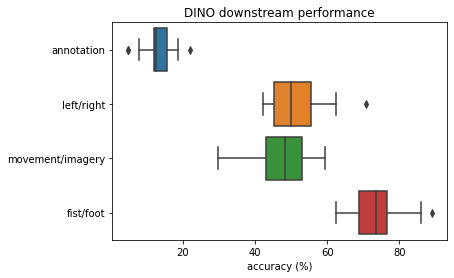

In [ ]:
performance['accuracy'] *= 100  # rescale to percentage

ax = sns.boxplot(data=performance, x='accuracy', y='task')
ax.set(xlabel='accuracy (%)', ylabel='', title='DINO downstream performance')
plt.savefig('./dino_downstream.png')
plt.show()

# Output

In [ ]:
# Download figure
if os.path.isfile('/content/dino_downstream.png'):
    files.download('/content/dino_downstream.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Download logs
!zip -r dino_logs.zip $LOGS_DIR
files.download('/content/dino_logs.zip')

  adding: logs/ (stored 0%)
  adding: logs/pretext/ (stored 0%)
  adding: logs/pretext/version_0/ (stored 0%)
  adding: logs/pretext/version_0/events.out.tfevents.1647484990.044e614c5e79.70.0 (deflated 82%)
  adding: logs/pretext/version_0/hparams.yaml (deflated 47%)
  adding: logs/pretext/version_0/checkpoints/ (stored 0%)
  adding: logs/pretext/version_0/checkpoints/epoch=2-step=827.ckpt (deflated 8%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>